In [3]:
import xarray
import numpy as np
import pandas
from matplotlib import pyplot as plt
import os
import gsw as TEOS_10
from dask.distributed import Client, LocalCluster


In [4]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39055 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39055/status,
Dashboard: /proxy/39055/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34231,Workers: 14
Dashboard: /proxy/39055/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:40395,Total threads: 1
Dashboard: /proxy/38267/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:41097,


In [5]:
CODA_path = '/g/data/es60/users/thomas_moore/CODA/'

dir_contents = os.listdir(CODA_path)
dir_contents.sort()


print(dir_contents)

START_YEAR = 2005
END_YEAR   = 2014


NORTH_LAT_LIM = -55
SOUTH_LAT_LIM = -90

WEST_LON_LIM = -180
EAST_LON_LIM =  180

DATA_SOURCE  = ['WOD2018']
#DATA_SOURCE  = ['AIMS']

OBS_PLATFORM = ['ctd'] #,'pfl'] #,'osd']
#OBS_PLATFORM = ['pfl']

DATA_VARIABLES = ['Temperature','Salinity'] #,'Oxygen','Nitrate']
#DATA_VARIABLES = ['Salinity']interpolate


['24092024-version', 'parquet']


In [72]:
profile_dataset

<xarray.Dataset>
Dimensions:                 (cast: 26194, z_index: 12958)
Coordinates:
  * cast                    (cast) int64 1 2 3 4 5 ... 26191 26192 26193 26194
    time                    (cast) datetime64[ns] ...
    lat                     (cast) float32 ...
    lon                     (cast) float32 ...
  * z_index                 (z_index) int64 0 1 2 3 ... 12954 12955 12956 12957
    z                       (cast, z_index) float32 ...
Data variables: (12/29)
    WOD_id                  (cast) int32 ...
    origflagset             (cast) |S100 ...
    country                 (cast) |S100 ...
    dataset                 (cast) |S100 ...
    Access_no               (cast) float64 ...
    Recorder                (cast) |S100 ...
    ...                      ...
    Chlorophyll_WODflag     (cast, z_index) float64 ...
    Chlorophyll_origflag    (cast, z_index) float32 ...
    z_WODflag               (cast, z_index) float64 ...
    z_origflag              (cast, z_index) float32 ...
    crs                     int32 ...
    CODA_id                 (cast) |S20 ...
Attributes:
    Parent ragged array file:  wod_ctd_2005.nc

In [74]:
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

average_temperature_by_year = []

MIN_Z = 100
MAX_Z = 160
for i_year in range(START_YEAR,END_YEAR+1):
    for i_platform in OBS_PLATFORM:
        for i_source in  DATA_SOURCE:
                
            file_to_get = i_source + '_CODA_' + str(i_year) + '_' + i_platform + '.nc'  #WOD_CODA_2010_pfl_test_all_vars.nc
            if os.path.isfile(os.path.join(CODA_path,str(i_year),file_to_get)):
                    
                profile_dataset  = xarray.open_dataset(os.path.join(CODA_path,str(i_year),file_to_get),mask_and_scale=True)
                print('Working on file: ', file_to_get)

                #Make sure that all data variables we are interested in 
                #are contained in the current profile
                
                if set(DATA_VARIABLES).issubset(profile_dataset.data_vars): #DATA_VARIABLES in profile_dataset.data_vars:
                    
                    variable_casts  = profile_dataset[i_var]
                    idx_casts_with_data = np.nonzero(np.logical_not(np.all(np.isnan(variable_casts),axis=1)).values)[0]
                    
                    profile_dataset_with_data = profile_dataset.isel(cast=idx_casts_with_data)
                        

                    lat_points = profile_dataset_with_data['lat'].values
                    lon_points = profile_dataset_with_data['lon'].values

                        #Get the profiles within the lat and lon boundaries provided above
                        
                    idx_in_lat_lon_lims = np.nonzero(np.logical_and(
                                                    np.logical_and(lat_points>=SOUTH_LAT_LIM,lat_points<=NORTH_LAT_LIM ) ,
                                                    np.logical_and(lon_points>=WEST_LON_LIM,lon_points<=EAST_LON_LIM ) ) )[0]

                        
                    profile_dataset_with_data_in_lims = profile_dataset_with_data.isel(cast=idx_in_lat_lon_lims)
                    n_casts,n_profile_index           = profile_dataset_with_data_in_lims[i_var].shape

                    #fig = plt.figure(figsize=[10, 5])
                    #ax = fig.add_subplot(1, 1, 1)                    
                    #ax.scatter(profile_dataset_with_data_in_lims['lon'],profile_dataset_with_data_in_lims['lat'])
                    #ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
                    #ax.add_feature(cfeature.LAND)
                    #ax.add_feature(cfeature.OCEAN)
                    
                    
                    #plt.figure(2)
                    #plt.scatter(profile_dataset_with_data_in_lims['Salinity'],profile_dataset_with_data_in_lims['Temperature'])

                    #plt.figure(3)
                    #plt.scatter(profile_dataset_with_data_in_lims['Temperature'],-profile_dataset_with_data_in_lims['z'])
                    #plt.show()

                    
                    

                    if n_casts != 0:
                        lat_points_in_lat_lon_lims     = profile_dataset_with_data_in_lims['lat']
                        lon_points_in_lat_lon_lims     = profile_dataset_with_data_in_lims['lon']
                        time_points_in_lat_lon_lims    = profile_dataset_with_data_in_lims['time']
                        CODA_id_points_in_lat_lon_lims = profile_dataset_with_data_in_lims['CODA_id']

                        n_casts = profile_dataset_with_data_in_lims['cast'].size

                        
                        average_temperature = 0
                        
                        for i_cast in range(0,profile_dataset_with_data_in_lims['time'].size):

                            current_temperature_profile = profile_dataset_with_data_in_lims['Temperature'].isel(cast=i_cast)
                            current_z_profile           = profile_dataset_with_data_in_lims['z'].isel(cast=i_cast)
                            
                            
                            current_temperature_profile_mask = current_temperature_profile.where(np.logical_and(current_z_profile>=MIN_Z , current_z_profile<=MAX_Z ) )
                            
                            #z_index = np.nonzero(np.logical_and(current_z_profile>=MIN_Z,current_z_profile<=MAX_Z) )[0]

                            average_temperature = average_temperature + current_temperature_profile.mean()
                         
                    #END n_cast
                    average_temperature_by_year.append(average_temperature/n_casts)

                            
          
                        

        #END for i_source
    #END for i_platform
#END for i_year

                        

                        

Working on file:  WOD2018_CODA_2005_ctd.nc
Working on file:  WOD2018_CODA_2006_ctd.nc
Working on file:  WOD2018_CODA_2007_ctd.nc
Working on file:  WOD2018_CODA_2008_ctd.nc
Working on file:  WOD2018_CODA_2009_ctd.nc
Working on file:  WOD2018_CODA_2010_ctd.nc
Working on file:  WOD2018_CODA_2011_ctd.nc
Working on file:  WOD2018_CODA_2012_ctd.nc
Working on file:  WOD2018_CODA_2013_ctd.nc
Working on file:  WOD2018_CODA_2014_ctd.nc


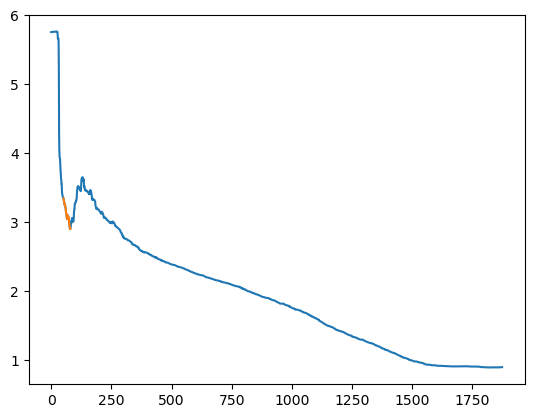

In [35]:
plt.plot(current_temperature_profile)
plt.plot(current_temperature_profile_mask)

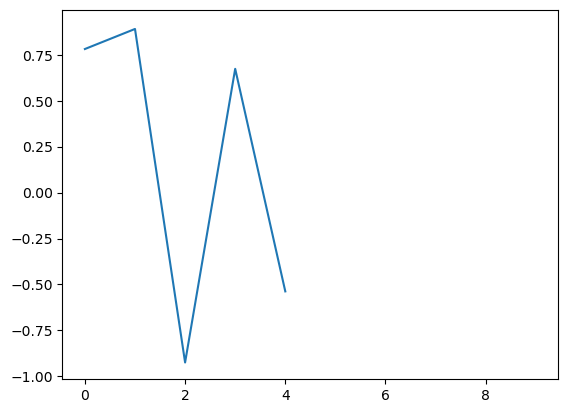

In [46]:
plt.plot(average_temperature_by_year)

In [32]:
current_z_profile[0:200]

<xarray.DataArray 'z' (z_index: 200)>
array([  0.      ,   1.981877,   3.963734,   5.945572,   7.927391,   9.909191,
        11.890971,  13.872734,  15.854475,  17.836195,  19.8179  ,  21.799585,
        23.781252,  25.762894,  27.744522,  29.72613 ,  31.707718,  33.68929 ,
        35.67084 ,  37.652367,  39.633877,  41.61537 ,  43.596848,  45.5783  ,
        47.55973 ,  49.54115 ,  51.52254 ,  53.503925,  55.485287,  57.466625,
        59.44794 ,  61.429237,  63.41052 ,  65.39178 ,  67.373024,  69.35425 ,
        71.33546 ,  73.316635,  75.2978  ,  77.27895 ,  79.26008 ,  81.24118 ,
        83.222275,  85.203354,  87.1844  ,  89.16542 ,  91.14644 ,  93.127426,
        95.108406,  97.08936 ,  99.0703  , 101.051216, 103.03212 , 105.01299 ,
       106.993835, 108.974686, 110.955505, 112.93631 , 114.9171  , 116.89786 ,
       118.87861 , 120.85932 , 122.84003 , 124.82072 , 126.80138 , 128.78203 ,
       130.76266 , 132.74327 , 134.72385 , 136.70444 , 138.68498 , 140.66551 ,
       142.64603 , 144.62654 , 146.60703 , 148.58746 , 150.5679  , 152.54832 ,
       154.5287  , 156.5091  , 158.48946 , 160.46982 , 162.45012 , 164.43042 ,
       166.41072 , 168.39098 , 170.37123 , 172.35146 , 174.33165 , 176.31184 ,
       178.29202 , 180.27217 , 182.2523  , 184.23242 , 186.21252 , 188.19258 ,
       190.17264 , 192.15268 , 194.13268 , 196.11267 , 198.09265 , 200.07262 ,
       202.05255 , 204.03247 , 206.01239 , 207.99226 , 209.9721  , 211.95197 ,
       213.9318  , 215.91159 , 217.89139 , 219.87117 , 221.85092 , 223.83061 ,
       225.81035 , 227.79004 , 229.76971 , 231.74936 , 233.729   , 235.7086  ,
       237.68819 , 239.66779 , 241.64735 , 243.62686 , 245.60641 , 247.58592 ,
       249.56538 , 251.54485 , 253.5243  , 255.50375 , 257.48312 , 259.46252 ,
       261.4419  , 263.42123 , 265.40057 , 267.37988 , 269.3592  , 271.33844 ,
       273.3177  , 275.29694 , 277.27612 , 279.25534 , 281.2345  , 283.21365 ,
       285.19278 , 287.1719  , 289.15106 , 291.1301  , 293.10916 , 295.08823 ,
       297.06723 , 299.04623 , 301.02524 , 303.00418 , 304.98312 , 306.96204 ,
       308.94098 , 310.91983 , 312.8987  , 314.8776  , 316.85645 , 318.83524 ,
       320.81403 , 322.79282 , 324.77155 , 326.7503  , 328.72903 , 330.70773 ,
       332.68637 , 334.66507 , 336.64374 , 338.6223  , 340.60092 , 342.57953 ,
       344.5581  , 346.53662 , 348.51517 , 350.49365 , 352.47217 , 354.45065 ,
       356.4291  , 358.4075  , 360.38593 , 362.36432 , 364.3427  , 366.32108 ,
       368.2994  , 370.27774 , 372.256   , 374.2343  , 376.21255 , 378.1908  ,
       380.16904 , 382.14725 , 384.12543 , 386.10358 , 388.08173 , 390.05988 ,
       392.038   , 394.01608 ], dtype=float32)
Coordinates:
    cast     int64 1774
    time     datetime64[ns] ...
    lat      float32 -55.5
    lon      float32 -150.0
  * z_index  (z_index) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198 199
    z        (z_index) float32 ...
Attributes:
    standard_name:        depth
    long_name:            depth_below_sea_surface
    units:                m
    positive:             down
    ancillary_variables:  z_sigfigs z_WODflag z_origflag